In [1]:
import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import pickle
import sys

# From arm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm

from lifting_transformer.lifting_transformer import (
    criterion,
    data,
    helper,
    inference,
    model,
    training,
)
from mausspaun.data_processing.dlc import (
    DLC_TO_MUJOCO_MAPPING,
    MUJOCO_TO_DLC_MAPPING,
    align_data_with_rig_markers,
)
from mausspaun.visualization.gui import app
from mausspaun.visualization.plot_3D_video import plot_3d_video, plot_split_3d_video

%load_ext autoreload
%autoreload 2

In [2]:
mouse_name = 'HoneyBee'
day = 77
attempt = 1
part = 0
base_path = '/data/mausspaun/'

In [3]:
# Test inference
(X_3d_test, X_2d_c1_test, X_2d_c2_test, cam_positions, likelihood_c1, likelihood_c2) = helper.load_single_session()
cam_positions_dict = {key: X_2d_c1_test[:, i, :] for i, key in enumerate(helper.mausspaun_keys)}
inference_preds = inference.run_inference(cam_positions_dict)

Shape of /data/markus/mausspaun/calibration/data/2018_mouse_reaching_rig5/calibration/CAL_front16.jpg is (280, 432), while at leat one previous image was of shape (300, 448).
Ignoring the mismatch and keeping the larger image: (300, 448).
[31, 32, 54, 73, 87, 96, 21, 41, 76, 64]
[152163, 432, 5]
MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391390369790641
Nan Values in 3D:  0
Nan Values in 2D Camera 1:  0
Nan Values in 2D Camera 2:  0
Total 3D (32, 4611, 3), Remaining 3D points (4611, 32, 3), 2D Camera 1 (4611, 32, 2), 2D Camera 2 (4611, 32, 2)
(4611, 32, 2)


Inference loss: 1.88097


In [4]:
avg_error, errors = inference.evaluate_ground_truth(inference_preds, mouse_name, day, attempt, verbose=2)

MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028

Overall Average Error: 0.20299792646953782
Average Error Per Marker:
 marker
joystick              0.133685
left_elbow           -1.000000
left_finger0          0.180174
left_finger1          0.214403
left_finger2          0.224748
left_finger3          0.419620
left_hand             0.164300
left_wrist            0.190739
lick                  0.256951
nose                  2.249819
right_elbow           0.130046
right_finger0_0       0.201809
right_finger0_1       0.203767
right_finger0_2       0.183565
right_finger0_3       0.177192
right_finger1_0       0.185978
right_finger1_1       0.184377
right_finger1_2       0.189802
right_finger1_3       0.184116
right_finger2_0       0.158768
right_finger2_1       0.146140
right_finger2_2       0.125897
right_finger2_3       0.132081
right_finger3_0       0.175006
right_finger3_1       0.125727
right_finger3_2       0.112460
right_finger3_3    

---
# Test triangulated 3D without using the transformer

In [5]:
# Original triangulated:
filepaths = app.generate_filepaths(base_path + 'videos/videos_dlc2/', mouse_name, day, attempt, part)
X_3d_train, X_2d_c1_train, X_2d_c2_train, cam_positions, likelihood_c1, likelihood_c2 = helper.get_training_data(
    filepaths[0][1], filepaths[1][1], likelihood_cutoff=0, convert_to_mujoco=False)
X_3d_train_dict = {key: X_3d_train[:, i, :] for i, key in enumerate(helper.mausspaun_keys)}
X_3d_train_mujoco, (dlc_c, dlc_s, T, mujoco_c, mujoco_s) = helper.dlc_to_mujoco(X_3d_train_dict.copy())

Shape of /data/markus/mausspaun/calibration/data/2018_mouse_reaching_rig5/calibration/CAL_front16.jpg is (280, 432), while at leat one previous image was of shape (300, 448).
Ignoring the mismatch and keeping the larger image: (300, 448).
[49, 45, 12, 89, 57, 18, 82, 58, 34, 65]
[152163, 432, 5]
Nan Values in 3D:  0
Nan Values in 2D Camera 1:  0
Nan Values in 2D Camera 2:  0
Total 3D (32, 4611, 3), Remaining 3D points (4611, 32, 3), 2D Camera 1 (4611, 32, 2), 2D Camera 2 (4611, 32, 2)
MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028


In [6]:
avg_error, errors = inference.evaluate_ground_truth(X_3d_train_mujoco, mouse_name, day, attempt, verbose=2)

MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028

Overall Average Error: 0.14169749928829228
Average Error Per Marker:
 marker
joystick              2.737469e-06
left_elbow           -1.000000e+00
left_finger0          5.921396e-02
left_finger1          2.250235e-02
left_finger2          4.866854e-02
left_finger3          3.405603e-01
left_hand             1.504562e-01
left_wrist            1.523506e-01
lick                  9.191131e-01
nose                  1.917610e+00
right_elbow           2.243991e-06
right_finger0_0       2.196880e-06
right_finger0_1       1.684020e-06
right_finger0_2       8.304622e-07
right_finger0_3       8.232992e-07
right_finger1_0       8.818575e-07
right_finger1_1       3.411930e-06
right_finger1_2       1.687735e-06
right_finger1_3       9.909085e-07
right_finger2_0       4.579007e-07
right_finger2_1       2.200803e-06
right_finger2_2       2.970170e-06
right_finger2_3       1.546481e-06
right_finger3_0     

---

---
# Project back to DLC space, then calculate reprojection error

In [9]:
inference_dlc = helper.mujoco_to_dlc(inference_preds.copy(), dlc_c, dlc_s, T, mujoco_c, mujoco_s)
inference_dlc_np = np.transpose(np.array([cp for key, cp in inference_dlc.items()]), axes=(1, 0, 2))
triangulated_3D_dlc = np.transpose(np.array([cp for key, cp in X_3d_train_dict.copy().items()]), axes=(1, 0, 2))

(all_cam1_transformer, all_cam2_transformer) = helper.project_from_3D_dlc(inference_dlc_np)
(all_cam1_triangulated, all_cam2_triangulated) = helper.project_from_3D_dlc(triangulated_3D_dlc)

errors_transformer_cam1 = helper.calculate_euclidean_error(X_2d_c1_train, all_cam1_transformer)
errors_transformer_cam2 = helper.calculate_euclidean_error(X_2d_c2_train, all_cam2_transformer)
errors_triangulated_cam1 = helper.calculate_euclidean_error(X_2d_c1_train, all_cam1_triangulated)
errors_triangulated_cam2 = helper.calculate_euclidean_error(X_2d_c2_train, all_cam2_triangulated)

Shape of /data/markus/mausspaun/calibration/data/2018_mouse_reaching_rig5/calibration/CAL_front16.jpg is (280, 432), while at leat one previous image was of shape (300, 448).
Ignoring the mismatch and keeping the larger image: (300, 448).
Shape of /data/markus/mausspaun/calibration/data/2018_mouse_reaching_rig5/calibration/CAL_front16.jpg is (280, 432), while at leat one previous image was of shape (300, 448).
Ignoring the mismatch and keeping the larger image: (300, 448).


/tmp/ipykernel_1733669/2000816055.py:5: RuntimeWarning: divide by zero encountered in log
  axes[idx].matshow(np.log(errors.T), aspect='auto')


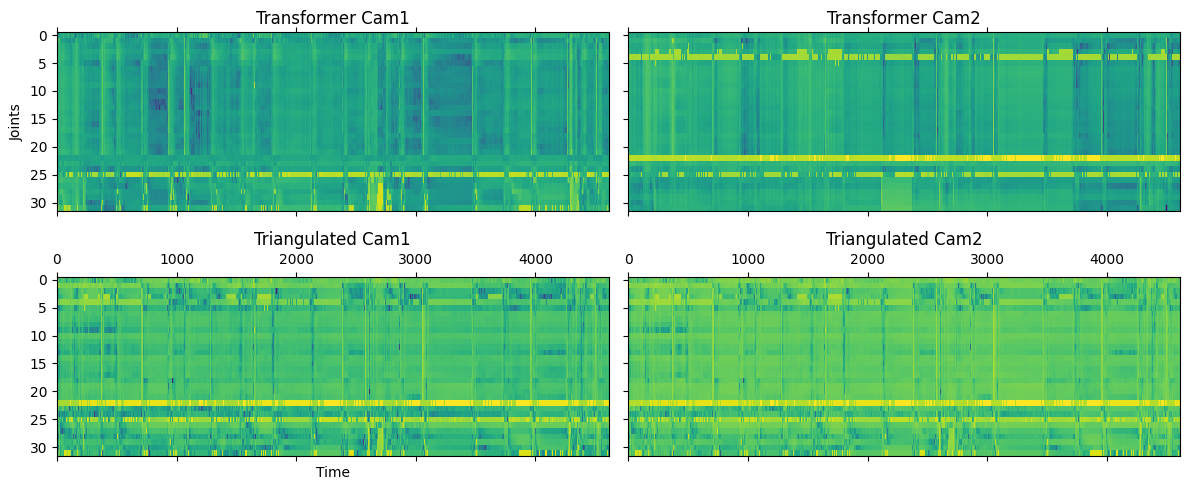

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (errors, txt) in enumerate(
        zip([errors_transformer_cam1, errors_transformer_cam2, errors_triangulated_cam1, errors_triangulated_cam2],
            ['Transformer Cam1', 'Transformer Cam2', 'Triangulated Cam1', 'Triangulated Cam2'])):
    axes[idx].matshow(np.log(errors.T), aspect='auto')
    axes[idx].set_title(txt)
axes[0].set_ylabel('Joints')
axes[2].set_xlabel('Time')
fig.tight_layout()